In [1]:
import os
import json
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.signal import butter, filtfilt

In [2]:
def get_cfg_files(base_path):
    cfg_dict = {}

    # Traverse the base directory
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)

        # Check if it's a directory
        if os.path.isdir(folder_path):
            cfg_files = []
            pat_info_path = None

            # Traverse files in the folder
            for file_name in os.listdir(folder_path):
                if file_name.endswith(".cfg"):
                    file_path = os.path.join(folder_path, file_name)
                    if file_name == "PatInfo.cfg":
                        pat_info_path = file_path
                    else:
                        cfg_files.append(file_path)

            # Add to dictionary if any .cfg files are found
            if pat_info_path or cfg_files:
                cfg_dict[folder_name] = {"patient_info": pat_info_path, "patient_data": cfg_files}

    return cfg_dict

In [3]:
test_dict = get_cfg_files("NewSavedData")
print(test_dict["FC_Astana_4"])

{'patient_info': 'NewSavedData\\FC_Astana_4\\PatInfo.cfg', 'patient_data': ['NewSavedData\\FC_Astana_4\\2025-07-03T14_14_10.cfg', 'NewSavedData\\FC_Astana_4\\2025-07-03T14_22_39.cfg', 'NewSavedData\\FC_Astana_4\\2025-07-03T14_28_03.cfg']}


In [4]:
def process_cfg_file(cfg_path):
    """Process a CFG file and extract the GlobalArray data"""
    try:
        with open(cfg_path, 'r', encoding='utf-8') as f:
            cfg_content = f.read()
    except Exception as e:
        print(f"Error reading file {cfg_path}: {e}")
        return None

    # Extract the GlobalArray data

    # Split the string into Info and GlobalArray parts
    info_part = cfg_content.split("Info=")[1].split("GlobalArray=")[0].strip()
    global_array_part = "[" + cfg_content.split("GlobalArray=[")[1]

    # Convert to Python dictionaries
    info = json.loads(info_part)
    global_array = json.loads(global_array_part)

    # Now you have two Python dictionaries
    if global_array is None:
        print("Failed to extract GlobalArray data")
        return None

    return info, global_array

In [5]:
cfg_path = Path(test_dict["FC_Astana_4"]["patient_data"][2])  # Correctly access the first CFG file path
if not cfg_path.exists():
    print(f"Error: File not found - {cfg_path}")
else:
    print(f"Processing {cfg_path}...")
    info, data = process_cfg_file(cfg_path)

    if data:
        print("\nSuccessfully extracted data:")
        print(json.dumps(data, indent=2))

Processing NewSavedData\FC_Astana_4\2025-07-03T14_28_03.cfg...

Successfully extracted data:
[
  {
    "Name": "ESP32_Sensor_1",
    "Sensor_1": 528,
    "Sensor_2": 0,
    "Sensor_3": 182,
    "Sensor_4": 0,
    "Time": "2172281",
    "XData": 319,
    "YData": -1,
    "ZData": -6
  },
  {
    "Name": "ESP32_Sensor_2",
    "Sensor_1": 335,
    "Sensor_2": 0,
    "Sensor_3": 0,
    "Sensor_4": 0,
    "Time": "2172281",
    "XData": 165,
    "YData": -15,
    "ZData": 12
  },
  {
    "Name": "ESP32_Sensor_1",
    "Sensor_1": 359,
    "Sensor_2": 0,
    "Sensor_3": 162,
    "Sensor_4": 70,
    "Time": "2172329",
    "XData": 319,
    "YData": -1,
    "ZData": -6
  },
  {
    "Name": "ESP32_Sensor_1",
    "Sensor_1": 373,
    "Sensor_2": 0,
    "Sensor_3": 97,
    "Sensor_4": 23,
    "Time": "2172396",
    "XData": 320,
    "YData": 1,
    "ZData": -10
  },
  {
    "Name": "ESP32_Sensor_2",
    "Sensor_1": 406,
    "Sensor_2": 0,
    "Sensor_3": 0,
    "Sensor_4": 0,
    "Time": "2172396"

In [6]:
def lowpass_filter(data, cutoff=5, fs=100, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y


def get_segmens(times, data, plateau_groups, sensor_name="Test", min_length=10):
    plt.figure(figsize=(12, 6))
    plt.plot(times, data, 'b-', linewidth=1, label='Filtered Data')
    segments = []
    for i, group in enumerate(plateau_groups):
        if len(group) >= min_length:
            start, end = group[0], group[-1] + 1  # +1 because we used diff earlier
            segments.append((times[start], times[end]))
            plt.plot(times[start:end+1], data[start:end+1],
                    'r-', linewidth=2, label='Plateau' if i == 0 else None)

    plt.title(f'{sensor_name}: Data with Plateau Regions)')
    plt.xlabel('Relative Time (ms)')
    plt.ylabel('Angle (degrees)')
    plt.grid(True)
    plt.legend()
    plt.show()
    return segments

def process_sensor_data(sensor_data, cutoff_frequency=10):
    # Extract time and XData values
    times = [int(data["Time"]) for data in sensor_data]
    x_data = [data["XData"] for data in sensor_data]

    # Convert angles to radians, unwrap, then back to degrees
    x_data = np.rad2deg(np.unwrap(np.deg2rad(x_data)))

    # Apply lowpass filter
    filtered_x_data = lowpass_filter(x_data, cutoff=cutoff_frequency)

    # Calculate relative time
    relative_times = [t - times[0] for t in times]

    return relative_times, filtered_x_data

def process_all_data(sensor_data_1, cutoff_frequency=10):
    times_1 = [int(data["Time"]) for data in sensor_data_1]
    z_data_1 = [data["XData"] for data in sensor_data_1]
    y_data_1 = [data["YData"] for data in sensor_data_1]
    x_data_1 = [data["ZData"] for data in sensor_data_1]

    sensor_1_1 = [data["Sensor_1"] for data in sensor_data_1]
    sensor_2_1 = [data["Sensor_2"] for data in sensor_data_1]
    sensor_3_1 = [data["Sensor_3"] for data in sensor_data_1]
    sensor_4_1 = [data["Sensor_4"] for data in sensor_data_1]

    # Convert angles to radians, unwrap, then back to degrees
    z_data_1 = np.rad2deg(np.unwrap(np.deg2rad(z_data_1)))
    y_data_1 = np.rad2deg(np.unwrap(np.deg2rad(y_data_1)))
    x_data_1 = np.rad2deg(np.unwrap(np.deg2rad(x_data_1)))

    # Apply lowpass filter
    filtered_z_data_1 = lowpass_filter(z_data_1, cutoff=cutoff_frequency)
    filtered_y_data_1 = lowpass_filter(y_data_1, cutoff=cutoff_frequency)
    filtered_x_data_1 = lowpass_filter(x_data_1, cutoff=cutoff_frequency)


    # Calculate relative time
    relative_times_1 = [t - times_1[0] for t in times_1]

    d = {
        "Time": relative_times_1,
        "X": filtered_x_data_1,
        "Y": filtered_y_data_1,
        "Z": filtered_z_data_1,
        "Sensor_1": sensor_1_1,
        "Sensor_2": sensor_2_1,
        "Sensor_3": sensor_3_1,
        "Sensor_4": sensor_4_1
    }

    df = pd.DataFrame(d)

    return df



def find_plateaus(data, threshold=1.0):
    derivative = np.diff(data)
    plateau_indices = np.where(np.abs(derivative) < threshold)[0]

    plateau_groups = []
    if len(plateau_indices) > 0:
        current_group = [plateau_indices[0]]
        for i in range(1, len(plateau_indices)):
            if plateau_indices[i] == plateau_indices[i-1] + 1:
                current_group.append(plateau_indices[i])
            else:
                plateau_groups.append(current_group)
                current_group = [plateau_indices[i]]
        plateau_groups.append(current_group)

    return plateau_groups


def filter_df(df, segments):
    # Create a list of filtered chunks
    filtered_chunks = [df[(df["Time"] >= start) & (df["Time"] <= end)] for start, end in segments]

    # Combine them into one DataFrame
    filtered_df = pd.concat(filtered_chunks, ignore_index=True)

    return filtered_df

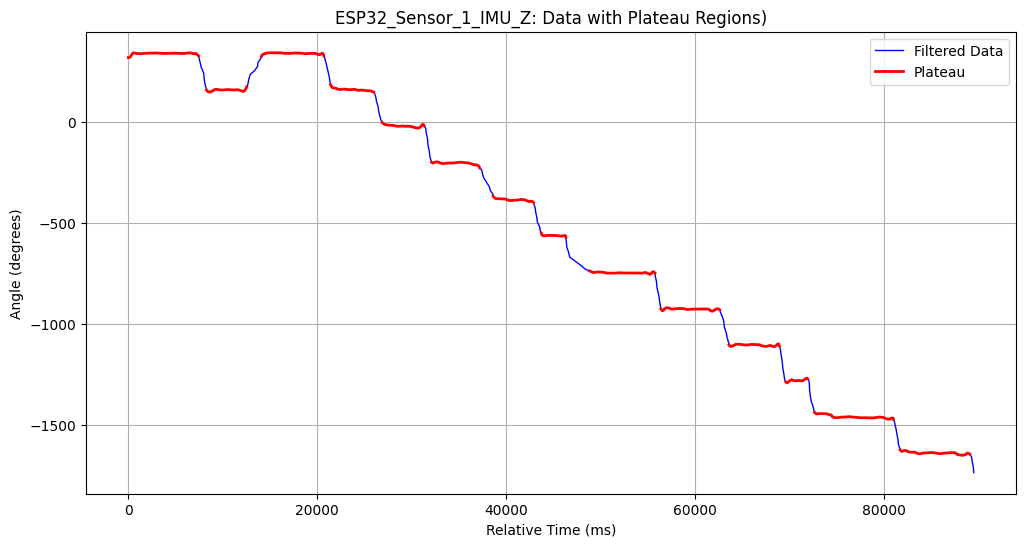

In [7]:
# Get sensor_data
sensor_data = [entry for entry in data if entry['Name'] == "ESP32_Sensor_1"]
sensor_data_2 = [entry for entry in data if entry['Name'] == "ESP32_Sensor_2"]

if not sensor_data:
    print("No data found for ESP32_Sensor_1")
else:
    relative_times, filtered_x_data = process_sensor_data(sensor_data)
    plateau_groups = find_plateaus(filtered_x_data, threshold=10)
    segments = get_segmens(relative_times, filtered_x_data, plateau_groups, sensor_name="ESP32_Sensor_1_IMU_Z")

In [8]:
print(segments)

[(0, 7447), (8281, 12531), (14098, 20698), (21414, 25982), (26881, 31314), (32113, 37198), (38632, 42897), (43729, 46330), (48830, 55762), (56396, 62630), (63597, 68929), (69596, 71929), (72662, 80996), (81712, 89096)]


In [9]:
df = process_all_data(sensor_data)

df.head()

,Time,X,Y,Z,Sensor_1,Sensor_2,Sensor_3,Sensor_4
0,0,-5.794015,-1.056108,319.016963,528,0,182,0
1,48,-11.646192,1.666737,318.840116,359,0,162,70
2,115,-16.774223,3.766699,319.379766,373,0,97,23
3,181,-20.548598,4.754115,321.142563,693,0,0,100
4,231,-22.660944,4.425729,324.245244,1265,0,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711 entries, 0 to 710
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      711 non-null    int64  
 1   X         711 non-null    float64
 2   Y         711 non-null    float64
 3   Z         711 non-null    float64
 4   Sensor_1  711 non-null    int64  
 5   Sensor_2  711 non-null    int64  
 6   Sensor_3  711 non-null    int64  
 7   Sensor_4  711 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 44.6 KB


In [11]:
filtered_df_1 = filter_df(df, segments)
filtered_df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      617 non-null    int64  
 1   X         617 non-null    float64
 2   Y         617 non-null    float64
 3   Z         617 non-null    float64
 4   Sensor_1  617 non-null    int64  
 5   Sensor_2  617 non-null    int64  
 6   Sensor_3  617 non-null    int64  
 7   Sensor_4  617 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 38.7 KB


In [12]:
df_2 = process_all_data(sensor_data_2)
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683 entries, 0 to 682
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      683 non-null    int64  
 1   X         683 non-null    float64
 2   Y         683 non-null    float64
 3   Z         683 non-null    float64
 4   Sensor_1  683 non-null    int64  
 5   Sensor_2  683 non-null    int64  
 6   Sensor_3  683 non-null    int64  
 7   Sensor_4  683 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 42.8 KB


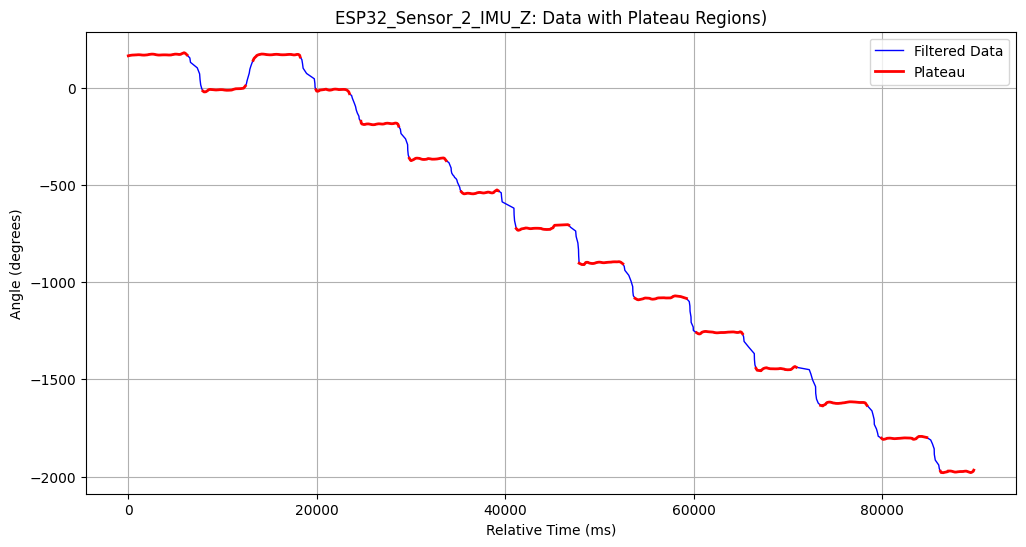

In [13]:
if not sensor_data_2:
    print("No data found for ESP32_Sensor_2")
else:
    relative_times_2, filtered_x_data_2 = process_sensor_data(sensor_data_2)
    plateau_groups_2 = find_plateaus(filtered_x_data_2, threshold=10)
    segments_2 = get_segmens(relative_times_2, filtered_x_data_2, plateau_groups_2, sensor_name="ESP32_Sensor_2_IMU_Z")

In [14]:
print(segments_2)

[(0, 6231), (7914, 12415), (13249, 18231), (19915, 23464), (24681, 28681), (29814, 33714), (35330, 39231), (41164, 46731), (47830, 52463), (53763, 59214), (60296, 65163), (66597, 70863), (73446, 78362), (79912, 84713), (86163, 89696)]


In [15]:
filtered_df_2 = filter_df(df_2, segments_2)
filtered_df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577 entries, 0 to 576
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Time      577 non-null    int64  
 1   X         577 non-null    float64
 2   Y         577 non-null    float64
 3   Z         577 non-null    float64
 4   Sensor_1  577 non-null    int64  
 5   Sensor_2  577 non-null    int64  
 6   Sensor_3  577 non-null    int64  
 7   Sensor_4  577 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 36.2 KB


In [16]:
filtered_df_1.head()

,Time,X,Y,Z,Sensor_1,Sensor_2,Sensor_3,Sensor_4
0,0,-5.794015,-1.056108,319.016963,528,0,182,0
1,48,-11.646192,1.666737,318.840116,359,0,162,70
2,115,-16.774223,3.766699,319.379766,373,0,97,23
3,181,-20.548598,4.754115,321.142563,693,0,0,100
4,231,-22.660944,4.425729,324.245244,1265,0,0,0


In [17]:
filtered_df_2.head()

,Time,X,Y,Z,Sensor_1,Sensor_2,Sensor_3,Sensor_4
0,0,11.771771,-14.999629,165.000196,335,0,0,0
1,115,20.226274,-15.360181,166.339130,406,0,0,0
2,231,27.213434,-15.629474,167.475165,443,0,0,0
3,348,31.660976,-15.737779,168.279817,501,0,0,0
4,414,33.328070,-15.647954,168.754005,551,0,0,592


In [18]:
sequence1 = filtered_df_1[['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4']].to_numpy()
sequence2 = filtered_df_2[['Sensor_1', 'Sensor_2', 'Sensor_3', 'Sensor_4']].to_numpy()

In [19]:
print(sequence1)

[[ 528    0  182    0]
 [ 359    0  162   70]
 [ 373    0   97   23]
 ...
 [2203    0 1117 1563]
 [2171    0 1264 1175]
 [3344  285   51  848]]


In [21]:
all_sequences = [sequence1, sequence2, ...]  # up to 20
with open("processed_data/FC_Astana_4_firstTry.pkl", "wb") as f:
    pickle.dump(all_sequences, f)

In [22]:
with open('processed_data/FC_Astana_4_firstTry.pkl', 'rb') as f:
    data = pickle.load(f)

In [23]:
data

[array([[ 528,    0,  182,    0],
        [ 359,    0,  162,   70],
        [ 373,    0,   97,   23],
        ...,
        [2203,    0, 1117, 1563],
        [2171,    0, 1264, 1175],
        [3344,  285,   51,  848]]),
 array([[ 335,    0,    0,    0],
        [ 406,    0,    0,    0],
        [ 443,    0,    0,    0],
        ...,
        [1250,  305,    0, 1954],
        [2306,  655,   18,  820],
        [1807,  506,    0, 1439]]),
 Ellipsis]